In [1]:
import sys
import os
sys.path.append('../..')
sys.path

['/opt/anaconda/envs/diffLIME/lib/python39.zip',
 '/opt/anaconda/envs/diffLIME/lib/python3.9',
 '/opt/anaconda/envs/diffLIME/lib/python3.9/lib-dynload',
 '',
 '/opt/anaconda/envs/diffLIME/lib/python3.9/site-packages',
 '/opt/anaconda/envs/diffLIME/lib/python3.9/site-packages/setuptools/_vendor',
 '../..']

In [141]:
import tensorflow as tf
from phmd import datasets
import numpy as np
from phm_framework.data import meta
from phm_framework.nets.dpm  import DiffusionModel
from tslearn.clustering import TimeSeriesKMeans
from tslearn.metrics import dtw
from tslearn.preprocessing import TimeSeriesScalerMinMax
from sklearn.cluster import KMeans
from tslearn.metrics import dtw
from scipy.signal import correlate
from sklearn.linear_model import LinearRegression
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from phm_framework.nets import dpm 
from phm_framework.data import prepare_data
from phm_framework.data import synthetic
from tqdm import tqdm

In [13]:
meta_att = [f"att{i}" for i in range(10)]

dpm_model = dpm.DiffusionModel(128,
                     widths=[32, 64, 64, 32, 32, 32],
                     block_depth=3,
                     num_features=len(meta_att),
                     timesteps=20,
                     cond=True,
                     envelopes=True,
                     feature_names=meta_att,
                     feature_loss_net=False,
                     feature_loss=False)

dpm_model.network = tf.keras.models.load_model("../../../weights/CWRU_DPM_v1.h5",
                                         custom_objects = {"Gather": dpm.Gather,
                                                           "Swish": dpm.Swish})

In [4]:
ds = datasets.Dataset("CWRU")
task = ds['fault']
sets = task[0]


X_train, M_train, Y_train = prepare_data(sets['train'], 'DE', subsignal_length=128, signal_max_length=20000)
_mmin, _mmax = M_train.min(axis=0), M_train.max(axis=0)


X_val, M_val, Y_val = prepare_data(sets['val'], 'DE', subsignal_length=128, signal_max_length=20000)


Dataset CWRU already downloaded and extracted
Remember to cite the original publisher dataset:
	@misc{caseBearingData,
		author = {},
		title = {{B}earing {D}ata {C}enter | {C}ase {S}chool of {E}ngineering | {C}ase {W}estern {R}eserve {U}niversity --- engineering.case.edu},
		howpublished = {\url{https://engineering.case.edu/bearingdatacenter}},
		year = {},
		note = {[Accessed 08-04-2024]},
	}
You can download the dataset manually from:  https://engineering.case.edu/bearingdatacenter

** If you find this tool useful, please cite our SoftwareX paper.



Reading data: 100%|██████████| 161/161 [00:02<00:00, 58.87it/s] 
INFO:root:Read in 5.088100433349609 seconds
INFO:root:It is possible stratified split? True
/opt/anaconda/envs/diffLIME/lib/python3.9/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
INFO:root:Read 3 sets: train,val,test
INFO:root:Columns: DE,unit,fault
INFO:root:Train shape: (28567988, 3)
INFO:root:Val shape: (7804030, 3)
INFO:root:Test shape: (979629, 3)
INFO:root:Meta-attributes extracted in 22.46406888961792 seconds
INFO:root:Meta-attributes extracted in 5.980592489242554 seconds


In [5]:
(X, E, M), (centroids, stds, kmeans) = synthetic.generate_synth_data(X_train, N=100000)    

/opt/anaconda/envs/diffLIME/lib/python3.9/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/opt/anaconda/envs/diffLIME/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


I0000 00:00:1734872740.716245   30900 cuda_dnn.cc:529] Loaded cuDNN version 90300


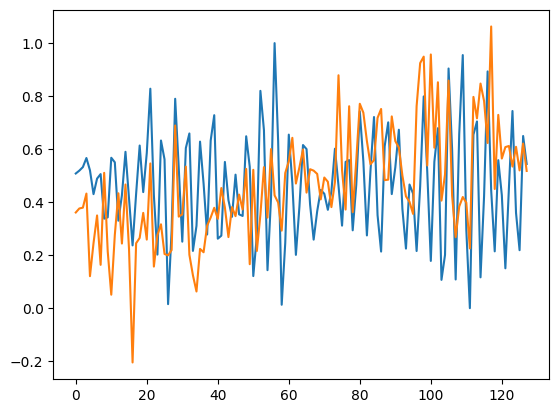

In [6]:
s = X_train[100]
f = synthetic.generate_meta(s, centroids)

f[-5] = 0.02

sn = synthetic.generate_synthetic_from_dpm(s, model, centroids, forced_features=f)


plt.plot(s)
plt.plot(sn)

In [14]:
from phm_framework.nets import cnn
from importlib import reload
reload(cnn)

nclasses = len(np.unique(Y_train))
EPOCHS = 200

results, cwru_model = cnn.train((np.expand_dims(X_train, axis=-1), Y_train), 
                           nclasses, 
                           EPOCHS, 
                           es=False, 
                           validation_data=(np.expand_dims(X_val, axis=-1), Y_val))


Epoch 1/3
153/153 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.4581 - loss: 1.3006 - val_accuracy: 0.4688 - val_loss: 1.1634
Epoch 2/3
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4758 - loss: 1.1375 - val_accuracy: 0.4688 - val_loss: 1.1505
Epoch 3/3
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4751 - loss: 1.1317 - val_accuracy: 0.4688 - val_loss: 1.1248
Epoch 1/200
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4834 - loss: 1.0860 - val_accuracy: 0.4936 - val_loss: 1.0722
Epoch 2/200
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5019 - loss: 1.0114 - val_accuracy: 0.4822 - val_loss: 1.0500
Epoch 3/200
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5263 - loss: 0.9639 - val_accuracy: 0.5355 - val_loss: 0.9394
Epoch 4/200
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5598 - loss: 0.9123 - val_accuracy: 0.5677 - val_loss: 0.9128
Epoch 5/200
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5744 - loss: 0.8991 - val_ac

Epoch 48/200
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7760 - loss: 0.5114 - val_accuracy: 0.6645 - val_loss: 0.7656
Epoch 49/200
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7803 - loss: 0.5104 - val_accuracy: 0.6609 - val_loss: 0.7882
Epoch 50/200
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7820 - loss: 0.5021 - val_accuracy: 0.6853 - val_loss: 0.7332
Epoch 51/200
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7915 - loss: 0.4927 - val_accuracy: 0.6935 - val_loss: 0.7217
Epoch 52/200
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7883 - loss: 0.4999 - val_accuracy: 0.6863 - val_loss: 0.7212
Epoch 53/200
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7949 - loss: 0.4814 - val_accuracy: 0.6757 - val_loss: 0.7684
Epoch 54/200
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7869 - loss: 0.4916 - val_accuracy: 0.6617 - val_loss: 0.7828
Epoch 55/200
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7937 - loss: 0

153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8737 - loss: 0.3155 - val_accuracy: 0.6687 - val_loss: 0.9867
Epoch 98/200
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8730 - loss: 0.3142 - val_accuracy: 0.6573 - val_loss: 0.9823
Epoch 99/200
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8806 - loss: 0.2982 - val_accuracy: 0.6783 - val_loss: 0.9090
Epoch 100/200
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8837 - loss: 0.2901 - val_accuracy: 0.6591 - val_loss: 0.9642
Epoch 101/200
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8835 - loss: 0.2933 - val_accuracy: 0.6851 - val_loss: 0.9587
Epoch 102/200
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8824 - loss: 0.2888 - val_accuracy: 0.6813 - val_loss: 0.9411
Epoch 103/200
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8811 - loss: 0.2820 - val_accuracy: 0.6843 - val_loss: 0.9215
Epoch 104/200
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8861 - loss: 0.2820 - 

153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9525 - loss: 0.1268 - val_accuracy: 0.6847 - val_loss: 1.5085
Epoch 147/200
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9497 - loss: 0.1328 - val_accuracy: 0.6793 - val_loss: 1.4712
Epoch 148/200
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9528 - loss: 0.1263 - val_accuracy: 0.6639 - val_loss: 1.6526
Epoch 149/200
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9490 - loss: 0.1320 - val_accuracy: 0.6797 - val_loss: 1.5718
Epoch 150/200
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9551 - loss: 0.1182 - val_accuracy: 0.6783 - val_loss: 1.5991
Epoch 151/200
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9606 - loss: 0.1071 - val_accuracy: 0.6801 - val_loss: 1.5782
Epoch 152/200
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9520 - loss: 0.1289 - val_accuracy: 0.6819 - val_loss: 1.5705
Epoch 153/200
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9585 - loss: 0.1101 

153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9942 - loss: 0.0244 - val_accuracy: 0.6771 - val_loss: 2.5306
Epoch 196/200
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9855 - loss: 0.0471 - val_accuracy: 0.6839 - val_loss: 2.1963
Epoch 197/200
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9580 - loss: 0.1123 - val_accuracy: 0.6763 - val_loss: 2.2737
Epoch 198/200
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9956 - loss: 0.0224 - val_accuracy: 0.6773 - val_loss: 2.4832
Epoch 199/200
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9974 - loss: 0.0168 - val_accuracy: 0.6797 - val_loss: 2.6662
Epoch 200/200
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9962 - loss: 0.0198 - val_accuracy: 0.6771 - val_loss: 2.6994


In [18]:
cwru_model.predict(X_val[0:1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


array([[2.7255660e-11, 1.0000000e+00, 2.8069254e-14, 8.6114975e-39]],
      dtype=float32)

In [371]:
#import cv2
import numpy as np
from sklearn.linear_model import Lasso, Ridge
from scipy.spatial.distance import cosine
import matplotlib

class DiffLIME:

    def __init__(self, model, dpm_model, envelopes, nsamples=1000, verbose=False):
        self.model = model
        self.dpm_model = dpm_model
        self.centroids = envelopes
        self.nsamples = nsamples
        self.random_state = 666
        self.verbose = verbose
        self._data = None
        self._targets = None
        

    def _get_weights(self):

        def distance_fn(x):
            ref = x[0]
            distance = np.zeros((x.shape[0],))
            for i in range(x.shape[0]):
                distance[i] = cosine(x[i], ref)
                #distance[i] = np.sum((x[i] * ref)**2)
            return distance

        distances = 1 - distance_fn(self._data)
        
        distances = (distances - np.min(distances)) / (np.max(distances) - np.min(distances))
        
        sigma = 1.0
        
        #return np.exp(-distances ** 2 / (2 * sigma ** 2)) 
        return distances

    def prepare_data(self, signal):
        dpm_model = self.dpm_model
        centroids = self.centroids
        
        
        self._data = np.zeros((self.nsamples, signal.shape[0]))
        self._targets = np.zeros((self.nsamples,))
        
        
        meta = synthetic.generate_meta(signal, centroids)

        self._data[0] = signal
        
        signal = np.squeeze(signal)
        probs = cwru_model.predict(np.array([signal]), verbose=0)
        prob = probs[0, probs.argmax()]
        
        source_klass = probs.argmax()
        self._targets[0] = prob
        source_prob = prob

        for i in range(self.nsamples-1):
            sn = synthetic.generate_synthetic_from_dpm(np.copy(signal), 
                                                       dpm_model, 
                                                       centroids, 
                                                       forced_features=meta, 
                                                       noise_ratio=0.02, 
                                                       N=1)

            probs = cwru_model.predict(np.array([sn]), verbose=0)
            prob = probs[0, klass]
            
            self._data[i+1] = sn
            self._targets[i+1] = prob
            #self._targets[i+1] = 1 if probs.argmax() == source_klass else 0
            
        return source_prob


    def explain(self, signal):
        
        if self._data is None:
            source_prob = self.prepare_data(signal)
        

        model_regressor = Ridge(alpha=1, fit_intercept=True, random_state=self.random_state)
        
        weights = self._get_weights()
        model_regressor.fit(self._data, self._targets, sample_weight=weights)
        
        prediction_score = model_regressor.score(self._data, self._targets, sample_weight=weights)
        local_pred = model_regressor.predict(signal.reshape(1,-1))
        
        if self.verbose:
            print(f'Intercept: {model_regressor.intercept_}')
            print(f'Local prediction: {local_pred}')
            print(f'Prediction score: {prediction_score}')
            
        
        #exp = sorted(enumerate(model_regressor.coef_), key=lambda x: np.abs(x[1]), reverse=True)
        exp = model_regressor.coef_
        return (model_regressor.intercept_, exp, prediction_score, local_pred, source_prob)


    """
    def display(self, input_array, explanation):

        s = input_array[0].squeeze()
        aux_hm = cv2.resize(explanation.T, dsize=s.shape, interpolation=cv2.INTER_CUBIC).T

        aux_hm =  (aux_hm - aux_hm.min()) / (aux_hm.max() - aux_hm.min())
        importances = [[(i, j, j+1, aux_hm[i,j]) for j in range(s.shape[1])] for i in range(s.shape[0])]

        display(s.T, importances)
    """


In [401]:
difflime = DiffLIME(cwru_model, dpm_model, centroids, nsamples=100)
#difflime._data = _data
#difflime._targets = _targets

_, explanation, prediction_score, local_pred, source_prob = difflime.explain(X_val[0])
prediction_score, local_pred, source_prob

(0.017966930731427966, array([0.84322115]), 1.0)

[0.59548877 0.60168847 0.60183094 0.65613111 0.69533195 0.72588312
 0.73043477 0.74137519 0.76201932 0.76941815 0.8136953  0.81780623
 0.83794128 0.85262298 0.86903698 0.87210253 0.88388429 0.93431843
 0.96782541 1.        ] [74 68 83 82 58 81 77 76 80 79 67 78 66 65 63 64 59 62 60 61]


/tmp/ipykernel_30900/784948266.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  text = f"Prediction Score: {float(prediction_score):.2f}\n\nLocal Prediction: {float(local_pred):.2f}\n\nSource Probability: {float(source_prob):.2f}"


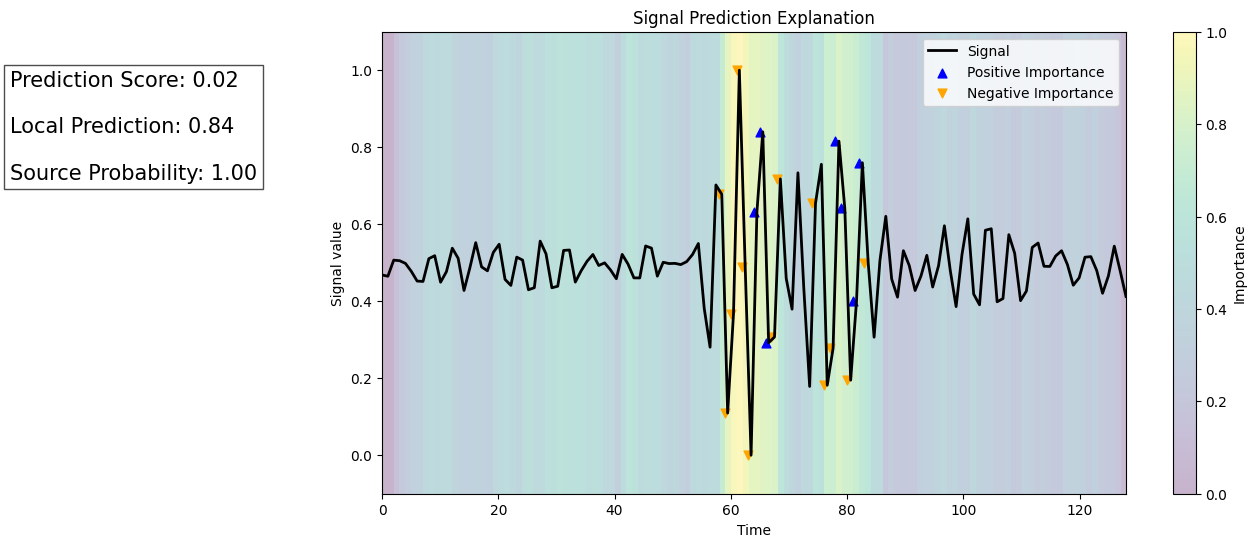

In [455]:
    
def plot_importances(signal, point_importances, prediction_score, local_pred, source_prob, topi=10):
    time = np.linspace(0, signal.shape[0], signal.shape[0])
    
    ini_importances = np.copy(point_importances)
    point_importances = np.abs(point_importances)
    
    # Función para suavizar las importancias usando una media móvil
    def smooth_importances(importancias, window_size=3):
        return np.convolve(importancias, np.ones(window_size) / window_size, mode='same')

    # Suavizar las importancias
    point_importances = smooth_importances(point_importances, window_size=10)

    # Normalizamos las importancias para que varíen entre 0 y 1
    norm_importancias = (point_importances - np.min(point_importances)) / (np.max(point_importances) - np.min(point_importances))

    top = np.sort(norm_importancias)[-topi:]
    top_arg = np.argsort(norm_importancias)[-topi:]
    print(top, top_arg)

    # Crear la figura
    plt.figure(figsize=(12, 6))  # Aumentar el ancho para espacio adicional

    # Usar un colormap para representar las importancias en el fondo
    cmap = matplotlib.colormaps['viridis']  # Colormap

    # Dibujar la señal en primer plano
    plt.plot(time, signal, label='Signal', color='black', linewidth=2)

    top_imp = ini_importances[top_arg]

    plt.scatter(top_arg[np.where(top_imp >= 0)], signal[top_arg][np.where(top_imp >= 0)], 
                c="blue", s=40, marker="^", label="Positive Importance")
    plt.scatter(top_arg[np.where(top_imp < 0)], signal[top_arg][np.where(top_imp < 0)], 
                c="orange", s=40, marker="v", label="Negative Importance")
    
    # Crear un fondo de color según la importancia
    width = np.max(signal) - np.min(signal)
    plt.imshow(norm_importancias.reshape(1, -1), aspect='auto', cmap=cmap, 
               extent=[time[0], time[-1], np.min(signal) - width*0.1, np.max(signal) + width*0.1], alpha=0.3)  # Fondo con colores

    # Añadir la información al lateral izquierdo
    text = f"Prediction Score: {float(prediction_score):.2f}\n\nLocal Prediction: {float(local_pred):.2f}\n\nSource Probability: {float(source_prob):.2f}"
    plt.text(-0.5 * len(signal), np.max(signal), text, 
             fontsize=15, va='top', ha='left', 
             bbox=dict(facecolor='white', alpha=0.7))

    # Etiquetas y título
    plt.colorbar(label='Importance')  # Barra de color para la importancia
    plt.xlabel('Time')
    plt.ylabel('Signal value')
    plt.title('Signal Prediction Explanation')

    # Mostrar la gráfica
    plt.legend(loc="upper right")
    plt.show()
    
plot_importances(X_val[0], explanation, prediction_score, local_pred, source_prob, topi=20)


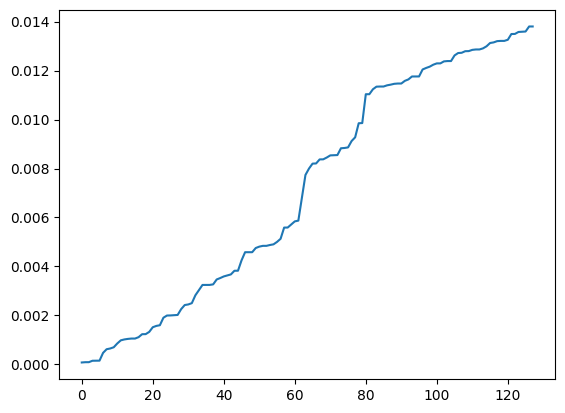

In [470]:
plt.plot(np.cumsum(np.abs(explanation)**2))